# TODO

1. Pick a Dataset
2. Download the dataset
3. Import the dataset using Pytorch
4. Explore the dataset
5. Prepare the dataset for training

In [1]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
od.download(dataset_url)

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [3]:
import os
from torchvision.datasets import ImageFolder
train_dir = './intel-image-classification/seg_test/seg_test'
test_dir = './intel-image-classification/seg_train/seg_train'

In [4]:
print("Classes:", ", ".join(os.listdir(train_dir)))

Classes: sea, street, forest, mountain, buildings, glacier


In [5]:
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir +'/'+ cls)))

sea : 510
street : 501
forest : 474
mountain : 525
buildings : 437
glacier : 553


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

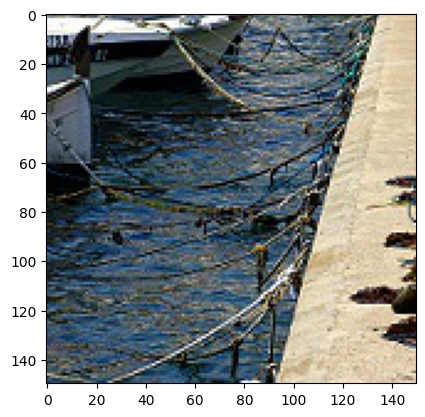

In [8]:
img, label = dataset[2001]
plt.imshow(img)

In [34]:
import torchvision.transforms as T
IMG_SIZE = 128
train_dataset = ImageFolder(train_dir,T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)),
                                            T.RandomCrop((IMG_SIZE, IMG_SIZE)),
                                            T.ToTensor()]))
test_dataset = ImageFolder(test_dir,T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)),
                                            T.ToTensor()]))

print(f"Training images: {len(train_dataset)}, Testing images {len(test_dataset)}")

Training images: 3000, Testing images 14034


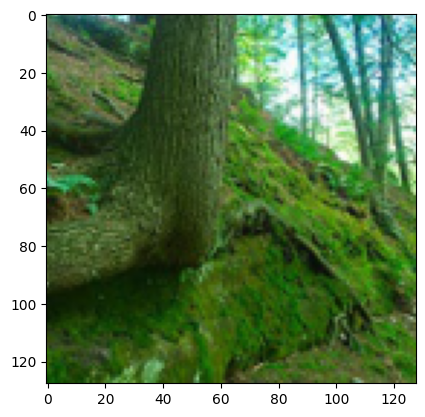

In [35]:
img, label = train_dataset[500]
plt.imshow(img.permute((1,2,0)))

In [36]:
from torch.utils.data import DataLoader
batch_size = 64

train_dl = DataLoader(train_dataset,
                      batch_size,
                      shuffle = True,
                      pin_memory = True,
                      num_workers = 5)
test_dl = DataLoader(test_dataset,
                      batch_size,
                      pin_memory = True,
                      num_workers = 5,
                      )

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
from torchvision.utils import make_grid

def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize = (30,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1,2,0))
        break

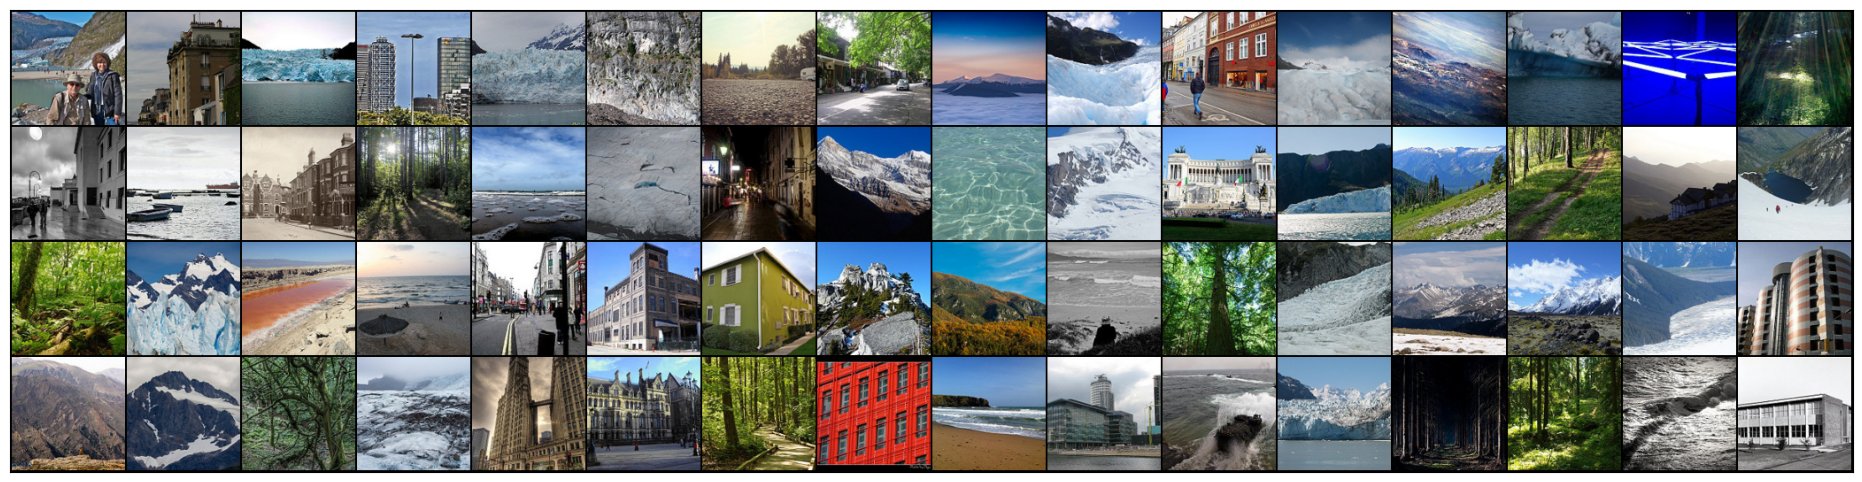

In [17]:
show_batch(train_dl)

## Utility functions and classes

In [18]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for bt in self.dl:
            yield to_device(bt,self.device)

    def __len__(self):
        return len(self.dl)


In [19]:
device = get_default_device()
device

device(type='cuda')

In [38]:
train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

# Model and Training Utilities 

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        # calculate loss for a batch of training data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss

    def validation_step(self,batch):
        # calculate loss & accuracy for a batch of validation data
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss': loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_losses = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accs.item()}

    def epoch_end(self,epoch,result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch,result['train_loss'],result['val_loss'],result['val_acc']))
    
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))


In [49]:
#Practice diff loss functions
# import torch.nn.functional as F
# input = torch.randn((3, 3), requires_grad=True)
# target = torch.rand((3, 3), requires_grad=False)
# loss = F.binary_cross_entropy(torch.sigmoid(input), target)
# input,target

In [86]:
@torch.no_grad()
def evaluate(model, val_loader):
    # Evalutes the models performance on the validation set
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
        val_loss, val_acc = outputs[-1].values()
        if val_acc > 0.85:
            torch.save(model, f"ResNet9 {round(val_acc.item(), 4)}.pth")
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

Resnet 9 architecture

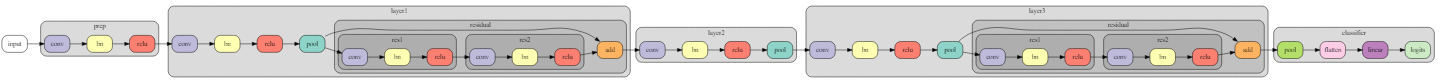

In [87]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  # Input: 128 x 64 x 128 x 128
        self.conv2 = conv_block(64, 128, pool=True) # Input: 128 x 128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), # Input: 128 x 128 x 64 x 64
                                  conv_block(128, 128)) # Input: 128 x 128 x 64 x 64
        
        self.conv3 = conv_block(128, 256, pool=True) # Input: 128 x 256 x 32 x 32
        self.conv4 = conv_block(256, 512, pool=True)  # Input: 128 x 512 x 16 x 16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # Input: 128 x 512 x 4 x 4
                                        nn.Flatten(), # Input: 128 x  512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [88]:
model = to_device(ResNet9(3,len(train_dataset.classes)),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [89]:
model.conv1[0].weight.device # Checking the model device

device(type='cuda', index=0)

Pass one batch of input tensor through the model.

In [90]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('',images.shape)
    print(images.device)
    preds = model(images)
    print('Preds shape',preds.shape)
    break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 torch.Size([64, 3, 128, 128])
cuda:0
Preds shape torch.Size([64, 6])


### Training

In [91]:
history = [evaluate(model,test_dl)]
history

[{'val_loss': 1.7939776182174683, 'val_acc': 0.17073863744735718}]

In [92]:
history += fit(30, 0.001, model, train_dl, test_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.6010, val_loss: 0.9708, val_acc: 0.6374
Epoch [1], train_loss: 0.9546, val_loss: 0.9215, val_acc: 0.6441
Epoch [2], train_loss: 0.8282, val_loss: 0.8103, val_acc: 0.7080
Epoch [3], train_loss: 0.7316, val_loss: 0.6738, val_acc: 0.7529
Epoch [4], train_loss: 0.6303, val_loss: 0.6440, val_acc: 0.7651
Epoch [5], train_loss: 0.5668, val_loss: 1.9009, val_acc: 0.5016
Epoch [6], train_loss: 0.4986, val_loss: 0.9380, val_acc: 0.6890
Epoch [7], train_loss: 0.4396, val_loss: 0.5749, val_acc: 0.7904
Epoch [8], train_loss: 0.4234, val_loss: 1.0580, val_acc: 0.6641
Epoch [9], train_loss: 0.4038, val_loss: 0.6351, val_acc: 0.7858
Epoch [10], train_loss: 0.3764, val_loss: 0.5093, val_acc: 0.8226
Epoch [11], train_loss: 0.3474, val_loss: 0.5276, val_acc: 0.8179
Epoch [12], train_loss: 0.3170, val_loss: 0.7130, val_acc: 0.7809
Epoch [13], train_loss: 0.2569, val_loss: 0.6074, val_acc: 0.8010
Epoch [14], train_loss: 0.2625, val_loss: 0.4487, val_acc: 0.8452
Epoch [15], train_lo